In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table

Filename: ../data/EuclidRubinData/53.0_-28.0/z_53.00_-28.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  IMAGE         1 ImageHDU        35   (3400, 3400)   float32   
  2  MASK          1 ImageHDU        52   (3400, 3400)   int32   
  3  VARIANCE      1 ImageHDU        35   (3400, 3400)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   30922R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  6  SkyWcs        1 BinTableHDU     17   588R x 1C   [1QB(15561)]   
  7  CoaddInputs    1 BinTableHDU     81   153R x 16C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  8  PhotoCalib    1 BinTableHDU     36   587R x 5C   [1X, 1D, 1D, 1J, 1J]   
  9  ChebyshevBoundedField    1 BinTableHDU     41   14671R x 6C   [1J, 1J, 1J, 1J, 1J, 1D]   
 10  CoaddInputs    2 BinTableHDU     90   433R x 18C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J,

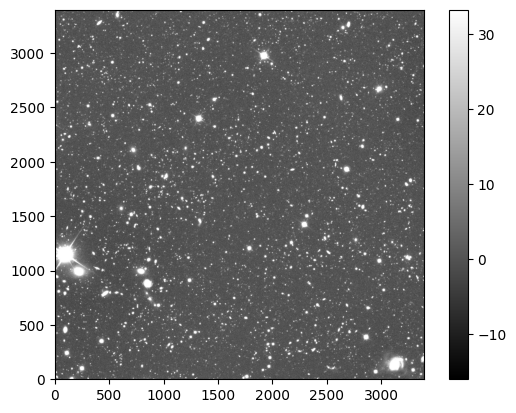

In [2]:
# Open the FITS file
hdul = fits.open('../data/EuclidRubinData/53.0_-28.0/z_53.00_-28.00.fits')
hdul.info()  # Lists HDUs (Header/Data Units) in the file
header = hdul[0].header

for key, value in header.items():
    print(f"{key:10} : {value}")
# Usually the image data is in the first HDU
image_data = hdul[1].data

zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(image_data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

# Close the FITS file
hdul.close()

# Simple plot
plt.imshow(image_data, cmap='gray', origin='lower', norm=norm)
plt.colorbar()
plt.show()

In [3]:
# Read .cat file (ignores lines starting with #)
catalog = Table.read('../data/EuclidRubinData/53.0_-28.0/z.cat', format='ascii')

# Show first few rows
print(catalog[:5])

# Access columns

 X_IMAGE  Y_IMAGE  FLUX_AUTO FLUXERR_AUTO ... B_IMAGE THETA_IMAGE NUMBER FLAGS
   pix      pix        ct         ct      ...   pix       deg                 
--------- -------- --------- ------------ ... ------- ----------- ------ -----
2375.0886 268.0146  57010.91     185.5348 ...   4.987       46.13      1     3
3388.8828 187.6023  434927.5     201.9361 ...    6.05       67.93      2    26
3124.8557 130.6079 1728749.0     632.0483 ...  17.862       30.98      3    18
 247.9779  98.8473 1695438.0      116.696 ...   3.675       76.41      4     4
3291.7043  83.7808  581763.5     105.3381 ...   3.362       45.09      5     0
